In [26]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from data_prep import fetch_data, set_target, backstep_columns, train_test_split
from model_utils import train_net, pred_accuracy, BasicData
from plotting_utils import plot_train_test

In [10]:
if torch.cuda.is_available():
    print("gpu available, using gpu")
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

gpu available, using gpu


In [11]:
df = fetch_data(augment=True)
df = set_target(df, 1)
targets = df['target']
features = df.drop('target', axis=1)
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns)
backsteps = 10
shaped_features = backstep_columns(scaled_features, backsteps)
targets = targets[backsteps:]
X_train, X_test, y_train, y_test = train_test_split(shaped_features, targets, percentile=0.5)

In [12]:
training_data = BasicData(X_train, y_train, device)
test_data = BasicData(X_test, y_test, device)
train_loader = DataLoader(training_data, batch_size=256, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True, drop_last=True)

In [13]:
l = [1,2,3]
print(l.pop())
print(l)

3
[1, 2]


In [24]:
class DeepNet(nn.Module):

    def __init__(self, input_size, num_layers, hidden_layers, out_d):
        """
        input_size: number of features
        num_layers: number of LSTM layers
        hidden_layers: list of sizes of connected layers
        out_d: dimension of target data
        """
        super(DeepNet, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_layers[0]
            
#         self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True)


        
        layers = []
        previous = num_layers * self.hidden_size
        for size in hidden_layers[1:]:
            layers.append(nn.Linear(previous, size))
            layers.append(nn.ReLU())
            previous = size
        layers.append(nn.Linear(previous, out_d))
        self.fcs = nn.Sequential(*layers)

    def forward(self, x):
        h_0 = x.new_zeros(
            self.num_layers, x.shape[0], self.hidden_size)

        c_0 = x.new_zeros(
            self.num_layers, x.shape[0], self.hidden_size)


        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))


        h_out = h_out.transpose(1,0).reshape(x.shape[0],-1)


        out = self.fcs(h_out)

        return out

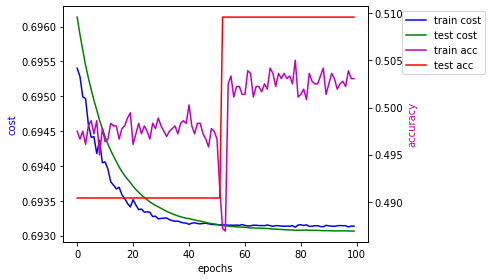

In [30]:
model = DeepNet(25, 20, [50, 25, 25, 10, 10, 10, 10, 10, 10, 10], 1)
model.to(device)

train_history, test_history = train_net(
    model, train_loader, test_data, loss_fn=torch.nn.BCEWithLogitsLoss(), epochs=100, learning_rate=0.01)
plot_train_test(train_history, test_history)